# Assignment 4

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

tf.get_logger().setLevel('INFO')

---
### Step 1: Data ingestion

You'll train a binary classifier using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. Note also that Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [5]:
# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


---
### Step 2: Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) and Data Preprocessing are often iterative processes that involve going back and forth to refine and improve the quality of data analysis and preparation. However, the specific order can vary depending on the project's requirements. In some cases, starting with EDA, as you see in this assignment, could be more useful, but there is no rigid rule dictating the sequence in all situations.

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following tasks:

1. Print the shapes and types of (X_train, Y_train) and (X_test, Y_test). Interpret the shapes (i.e., what do the numbers represent?). Hint: For types use the <span style="color:chocolate">type()</span> function.
2. Define a list of strings of class names corresponding to each class in (Y_train, Y_test). Call this list label_names. Hint: Refer to the Fashion MNIST documentation.

In [26]:
# YOUR CODE HERE
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
label_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


The shape of the data represents the number of features as columns and the entries as rows. X datasets contain 60,000 training samples. Each sample is a 28x28 image. In the Y datasets a label is represented by an integer.

### <span style="color:chocolate">Exercise 2:</span> Getting to know your data - cont'd (5 points)

Fashion MNIST images have one of 10 possible labels (shown above).

Complete the following tasks:

1. Display the first 5 images in X_train for each class in Y_train, arranged in a 10x5 grid. Use the label_names list defined above;
2. Determine the minimum and maximum pixel values for images in the X_train dataset.

In [7]:
# YOUR CODE HERE
min_pixel_value = np.min(X_train)
max_pixel_value = np.max(X_train)

print(f"Minimum pixel value in X_train: {min_pixel_value}")
print(f"Maximum pixel value in X_train: {max_pixel_value}")

Minimum pixel value in X_train: 0
Maximum pixel value in X_train: 255


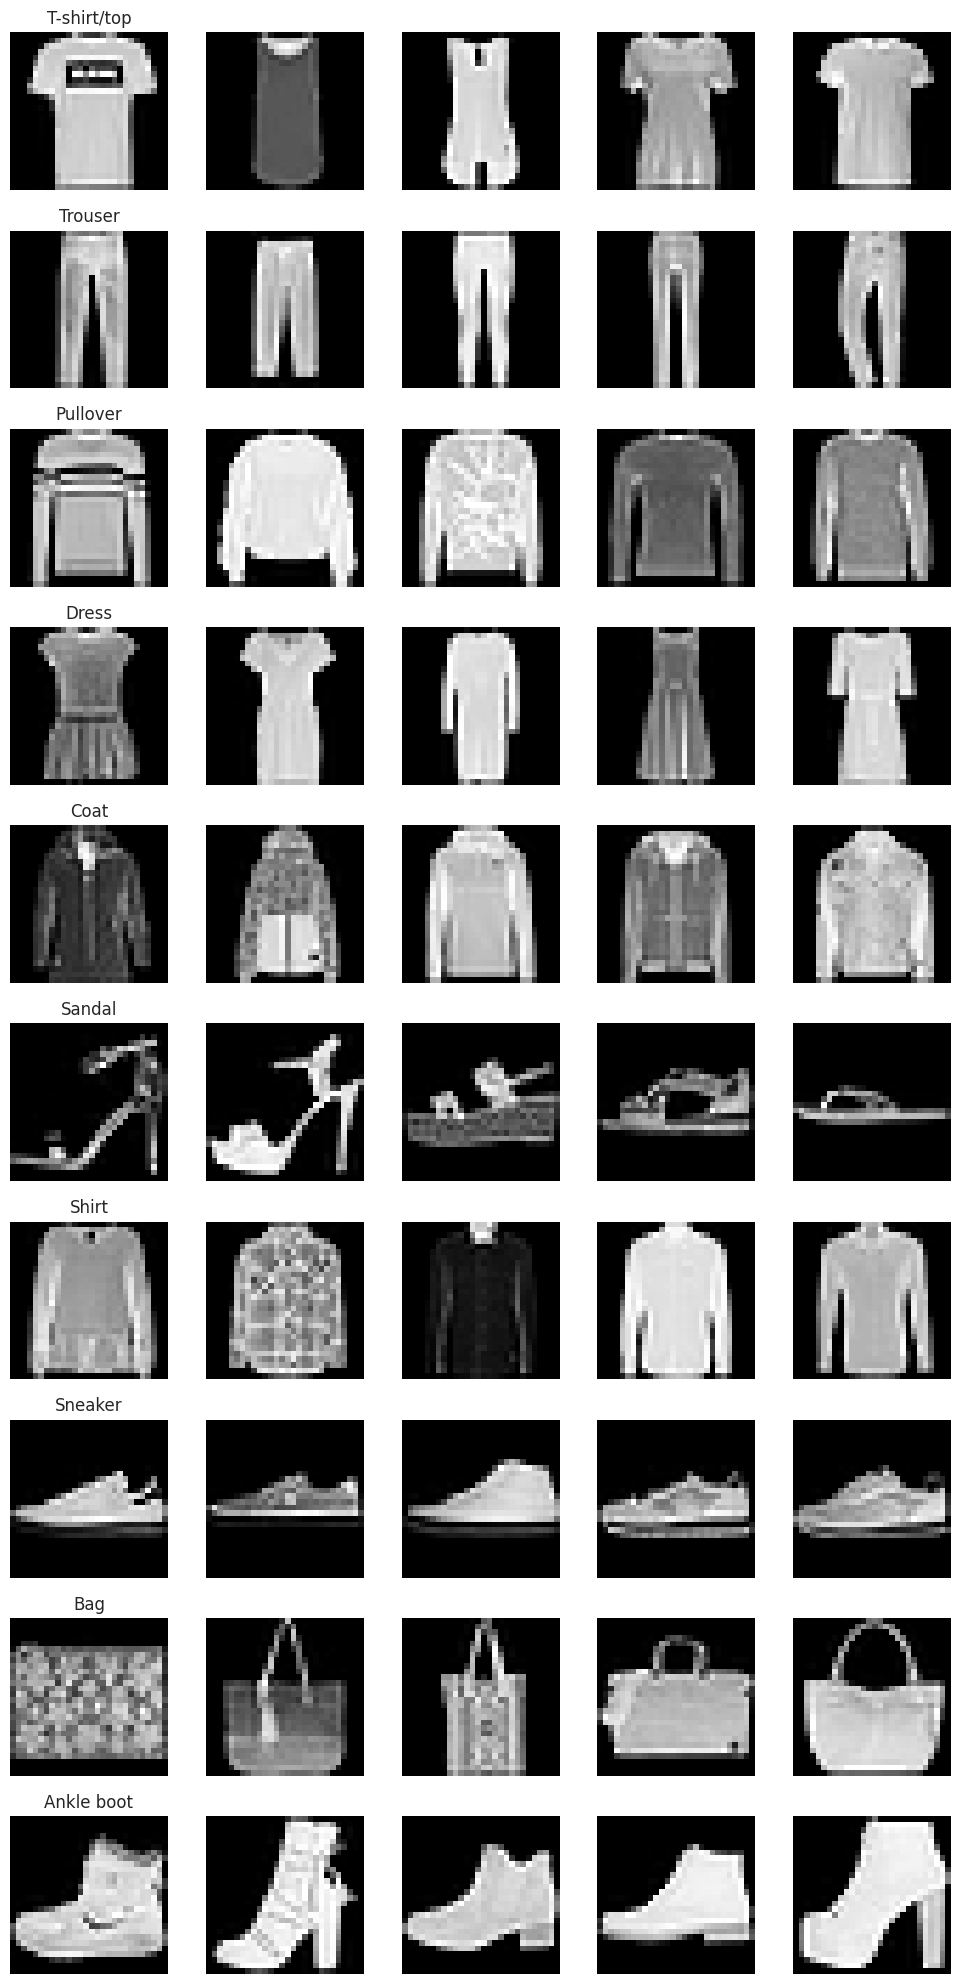

In [47]:
num_classes = len(label_names)
num_images_per_class = 5
# Create subplots
fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))

for class_idx in range(num_classes):
    # Get the indices of images that belong to the current class
    class_indices = np.where(Y_train == class_idx)[0]
    # Select the first num_images_per_class images of the current class
    class_images = X_train[class_indices[:num_images_per_class]]
    for img_idx in range(num_images_per_class):
        ax = axes[class_idx, img_idx]  # Select the subplot
        ax.imshow(class_images[img_idx], cmap='gray')  # Plot the image
        ax.axis('off')  # Hide the axis
        if img_idx == 0:
            ax.set_title(label_names[class_idx], fontsize=12)  # Set the title for the first image in the row

plt.tight_layout()
plt.show()

---
### Step 3: Data preprocessing

This step is essential for preparing this image data in a format that is suitable for ML algorithms.

### <span style="color:chocolate">Exercise 3:</span> Feature preprocessing (5 points)

In the previous lab, the input data had just a few features. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

In this exercise, you'll perform the following tasks:

1. Normalize the pixel values in both X_train and X_test data so they range between 0 and 1;
2. For each image in X_train and X_test, flatten the 2-D 28x28 pixel array to a 1-D array of size 784. Hint: use the <span style="color:chocolate">reshape()</span> method available in NumPy. Note that by doing so you will overwrite the original arrays;
3. Pint the shape of X_train and X_test arrays.

In [6]:
# YOUR CODE HERE
# Normalize pixel values to range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten the images from 2D (28x28) to 1D (784)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Print the shapes of the arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Determine the minimum and maximum pixel values for images in X_train
min_pixel_value = np.min(X_train)
max_pixel_value = np.max(X_train)

print(f"Minimum pixel value in X_train: {min_pixel_value}")
print(f"Maximum pixel value in X_train: {max_pixel_value}")


Shape of X_train: (60000, 784)
Shape of X_test: (10000, 784)
Minimum pixel value in X_train: 0.0
Maximum pixel value in X_train: 1.0


### <span style="color:chocolate">Exercise 4:</span> Label preprocessing (5 points)

This assignment involves binary classification. Specifically, the objective is to predict whether an image belongs to the sneaker class (class 7) or not.

Therefore, write code so that for each example in (Y_train, Y_test), the outcome variable is represented as follows:
* $y=1$, for sneaker class (positive examples), and
* $y=0$, for non-sneaker class (negative examples).

Note: To avoid "ValueError: assignment destination is read-only", first create a copy of the (Y_train, Y_test) data and call the resulting arrays (Y_train, Y_test). Then overwrite the (Y_train, Y_test) arrays to create binary outcomes.

In [7]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

# Check unique values in the original Y_test before conversion
print("Unique values in original Y_test:", np.unique(Y_test))
# YOUR CODE HERE
Y_train.shape
Y_train[Y_train != 7] = 0
Y_train[Y_train == 7] = 1
Y_test[Y_test != 7] = 0
Y_test[Y_test == 7] = 1
np.unique(Y_test)
#MAKE SURE TO ONLY RUN THIS ONCE

Unique values in original Y_test: [0 1 2 3 4 5 6 7 8 9]


array([0, 1], dtype=uint8)

### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Retain 20% from the training data for validation purposes. Set random state to 1234. Name the resulting dataframes as follows: X_train_mini, X_val, Y_train_mini, Y_val.
2. Print the shape of each array.

In [8]:
# YOUR CODE HERE
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234)

print("Shape of X_train_mini:", X_train_mini.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train_mini:", Y_train_mini.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train_mini: (48000, 784)
Shape of X_val: (12000, 784)
Shape of Y_train_mini: (48000,)
Shape of Y_val: (12000,)


### <span style="color:chocolate">Exercise 6:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative.

1. Use [integer array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing) to re-order (X_train_mini, Y_train_mini) using a list of shuffled indices. In doing so, you will overwrite the arrays.

In [9]:
np.random.seed(0)
# YOUR CODE HERE

# Generate a list of shuffled indices
num_samples = len(X_train_mini)
shuffled_indices = np.random.permutation(num_samples)

# Reorder X_train_mini and Y_train_mini using shuffled indices
X_train_mini = X_train_mini[shuffled_indices]
Y_train_mini = Y_train_mini[shuffled_indices]
print(X_train_mini.shape)
print(Y_train_mini.shape)

(48000, 784)
(48000,)


---
### Step 4: Exploratory Data Analysis (EDA) - cont'd

Before delving into model training, let's further explore the raw feature values by comparing sneaker and non-sneaker training images.

### <span style="color:chocolate">Exercise 7:</span> Pixel distributions (10 points)

1. Identify all sneaker images in X_train_mini and calculate the mean pixel value for each sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all sneaker images.
2. Identify all non-sneaker images in X_train_mini and calculate the mean pixel value for each non-sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all non-sneaker images.
3. Based on the histogram results, assess whether there is any evidence suggesting that pixel values can be utilized to distinguish between sneaker and non-sneaker images. Justify your response.

Notes: Make sure to provide a descriptive title and axis labels for each histogran. Make sure you utilize Y_train_mini to locate the sneaker and non-sneaker class.

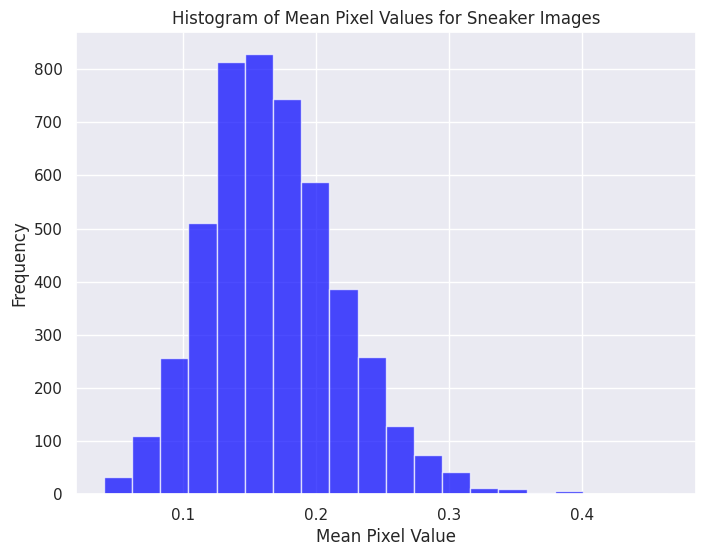

Mean Pixel Value Across All Sneaker Images: 0.1682747275993731


In [65]:
# YOUR CODE HERE
# Identify all sneaker images in X_train_mini
sneaker_indices = np.where(Y_train_mini == 1)[0]
sneaker_images = X_train_mini[sneaker_indices]

# Calculate the mean pixel value for each sneaker image
mean_pixel_values = np.mean(sneaker_images, axis=1)

# Visualize pixel values using a histogram
plt.figure(figsize=(8, 6))
plt.hist(mean_pixel_values, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Mean Pixel Values for Sneaker Images')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print the mean pixel value across all sneaker images
overall_mean_pixel_value = np.mean(mean_pixel_values)
print("Mean Pixel Value Across All Sneaker Images:", overall_mean_pixel_value)

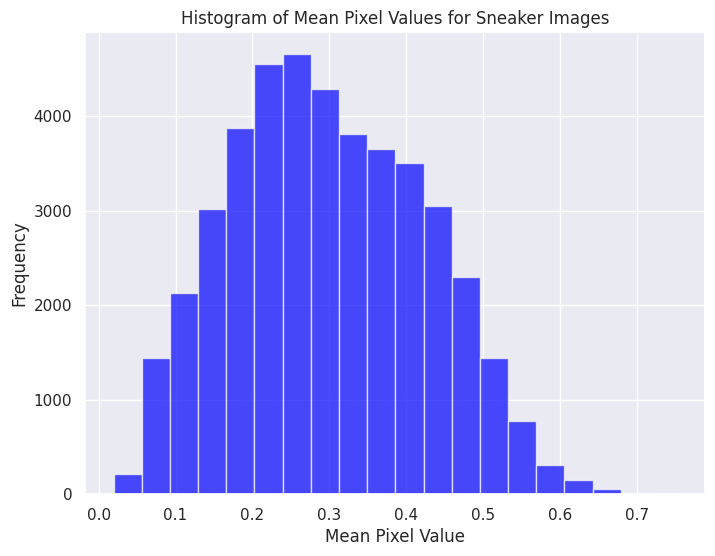

Mean Pixel Value Across All Sneaker Images: 0.29900192681239157


In [64]:

non_sneaker_indices = np.where(Y_train_mini != 1)[0]
non_sneaker_images = X_train_mini[non_sneaker_indices]

# Calculate the mean pixel value for each sneaker image
non_mean_pixel_values = np.mean(non_sneaker_images, axis=1)

# Visualize pixel values using a histogram
plt.figure(figsize=(8, 6))
plt.hist(non_mean_pixel_values, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Mean Pixel Values for Sneaker Images')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print the mean pixel value across all sneaker images
non_overall_mean_pixel_value = np.mean(non_mean_pixel_values)
print("Mean Pixel Value Across All Sneaker Images:", non_overall_mean_pixel_value)

In [69]:
mean_diff_pct=((non_overall_mean_pixel_value-overall_mean_pixel_value)/overall_mean_pixel_value)*100
print(mean_diff_pct)

77.6867691768027


Based on the histogram results, if we observe clear separation between the distributions of mean pixel values for sneaker and non-sneaker images with minimal overlap and consistent variability within each class, it suggests that pixel values could be utilized to distinguish between sneaker and non-sneaker images. The non-sneaker mean pixel value is 77% larger than the sneaker mean pixel value so it is distinguishable.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 8:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

With this information in mind:

1. What is the number of sneaker images in Y_train_mini?
2. What is the number of non-sneaker images in Y_train_mini?
3. What is the majority class in Y_train_mini?
4. What is the accuracy of a majority class classifier for Y_train_mini?
5. Implement a function that computes the Log Loss (binary cross-entropy) metric and use it to evaluate this baseline on both the mini train (Y_train_mini) and validation (Y_val) data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in the mini training data). Hint: for additional help, see the file ``04 Logistic Regression with Tensorflow_helpers.ipynb``.

In [10]:
# YOUR CODE HERE
num_sneakers = np.sum(Y_train_mini == 1)
print("Number of sneaker images in Y_train_mini:", num_sneakers)

num_non_sneakers = np.sum(Y_train_mini == 0)
print("Number of non-sneaker images in Y_train_mini:", num_non_sneakers)

majority_class = 1 if num_sneakers > num_non_sneakers else 0
print("Majority class in Y_train_mini:", "Sneaker" if majority_class == 1 else "Non-sneaker")

total_samples = len(Y_train_mini)
majority_class_count = max(num_sneakers, num_non_sneakers)
majority_class_accuracy = majority_class_count / total_samples
print("Accuracy of a majority class classifier for Y_train_mini:", majority_class_accuracy)

Number of sneaker images in Y_train_mini: 4800
Number of non-sneaker images in Y_train_mini: 43200
Majority class in Y_train_mini: Non-sneaker
Accuracy of a majority class classifier for Y_train_mini: 0.9


In [12]:
def binary_cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0) which is undefined
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

    # Calculate binary cross-entropy loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#creates an array full of 0.1 same dims as Y_train
#and assumes that our baseline model makes that prediction for every single input
predicted_probability = 0.1
y_pred_baseline_train = np.full(Y_train_mini.shape, predicted_probability)
y_pred_baseline_val = np.full(Y_val.shape, predicted_probability)

# Calculate the log loss for the mini train and validation data
loss_train = binary_cross_entropy_loss(Y_train_mini, y_pred_baseline_train)
loss_val = binary_cross_entropy_loss(Y_val, y_pred_baseline_val)

print("Baseline Log Loss on mini train data:", loss_train)
print("Baseline Log Loss on validation data:", loss_val)

Baseline Log Loss on mini train data: 0.3250829733914482
Baseline Log Loss on validation data: 0.3250829733914482


### <span style="color:chocolate">Exercise 9:</span> Improvement over Baseline with TensorFlow (10 points)

Let's use TensorFlow to train a binary logistic regression model much like you did in the previous assignment. The goal here is to build a ML model to improve over the baseline classifier.

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: the activation function, the loss, and the evaluation metric are different compared to the linear regression model;
2. Build and compile a model using the build_model() function and the (X_train_mini, Y_train_mini) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_mini, Y_train_mini) data. Set num_epochs = 5 and batch_size=32. Pass the (X_val, Y_val) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot (for the mini training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

In [13]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
        units=1,                       # Single output unit for binary classification
        input_shape=(num_features,),   # Input shape should match the number of features
        use_bias=True,                 # Use bias (intercept)
        activation='sigmoid',          # Sigmoid activation function for binary classification
        kernel_initializer=tf.keras.initializers.Ones(),  # Initialize weights to 1
        bias_initializer=tf.keras.initializers.Ones()     # Initialize bias to 1
  ))


  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

  return model

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 205.6167 - accuracy: 0.1000 - val_loss: 199.9825 - val_accuracy: 0.1000
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 193.0895 - accuracy: 0.1000 - val_loss: 187.4252 - val_accuracy: 0.1000
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 180.5630 - accuracy: 0.1000 - val_loss: 174.8679 - val_accuracy: 0.1000
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 168.0361 - accuracy: 0.1000 - val_loss: 162.3107 - val_accuracy: 0.1000
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 155.5091 - accuracy: 0.1000 - val_loss: 149.7533 - val_accuracy: 0.1000


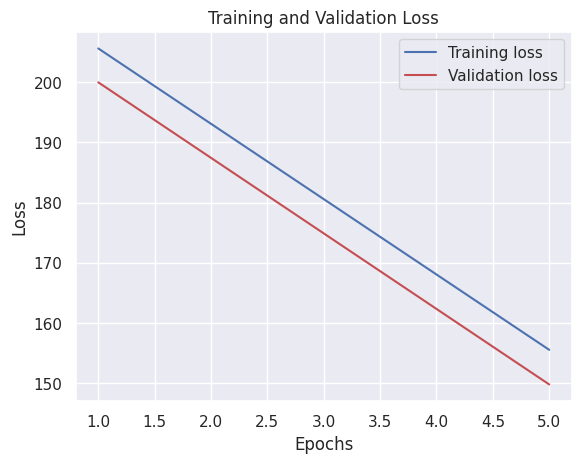

In [14]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
# Set the learning rate
learning_rate = 0.0001

# Build and compile the model
model_tf = build_model(num_features=X_train_mini.shape[1], learning_rate=learning_rate)

num_epochs = 5
batch_size = 32

history = model_tf.fit(X_train_mini, Y_train_mini,
                       epochs=num_epochs,
                       batch_size=batch_size,
                       validation_data=(X_val, Y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting loss values
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 10:</span> Hyperparameter tuning (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the mini training and validation datasets;
4. The percentage difference between the losses observed on the mini training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?


Please note that we will consider 'optimal model configuration' any last-epoch loss that is below 0.08.

In [15]:
# YOUR CODE HERE
# Set the learning rate
learning_rate = 0.01

# Build and compile the model
model_tf2 = build_model(num_features=X_train_mini.shape[1], learning_rate=learning_rate)

num_epochs = 20
batch_size = 32

history2 = model_tf2.fit(X_train_mini, Y_train_mini,
                       epochs=num_epochs,
                       batch_size=batch_size,
                       validation_data=(X_val, Y_val))

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(train_loss2) + 1)

Epoch 1/20
1500/1500 [==============================] - 4s 2ms/step - loss: 19.2664 - accuracy: 0.7237 - val_loss: 0.6340 - val_accuracy: 0.9037
Epoch 2/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4705 - accuracy: 0.9193 - val_loss: 0.3828 - val_accuracy: 0.9284
Epoch 3/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3232 - accuracy: 0.9331 - val_loss: 0.2893 - val_accuracy: 0.9377
Epoch 4/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2523 - accuracy: 0.9424 - val_loss: 0.2350 - val_accuracy: 0.9438
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2099 - accuracy: 0.9479 - val_loss: 0.1997 - val_accuracy: 0.9475
Epoch 6/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1820 - accuracy: 0.9523 - val_loss: 0.1727 - val_accuracy: 0.9523
Epoch 7/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1624 - accuracy: 0.9554 - val_loss: 0.1550 - val_accuracy

In [20]:
# Retrieve the first five learned parameters of the model (including bias term)
first_five_parameters = model_tf2.get_weights()[0][:5]

# Get the final loss values from the history object
final_train_loss = history2.history['loss'][-1]
final_val_loss = history2.history['val_loss'][-1]

# Calculate the percentage difference between training and validation losses
percentage_difference = ((final_train_loss - final_val_loss) / final_val_loss) * 100

# Print the results
print("First five learned parameters of the model (including bias term):", first_five_parameters)
print("Final loss on mini training dataset:", final_train_loss)
print("Final loss on validation dataset:", final_val_loss)
print("Percentage difference between mini training and validation losses:", percentage_difference)


First five learned parameters of the model (including bias term): [[0.9998243 ]
 [0.9994962 ]
 [0.99642074]
 [0.9883888 ]
 [0.9706232 ]]
Final loss on mini training dataset: 0.07928959280252457
Final loss on validation dataset: 0.07564521580934525
Percentage difference between mini training and validation losses: 4.8177230432715525


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 11:</span> Computing accuracy (10 points)

1. Calculate aggregate accuracy on both mini train and test datasets using a probability threshold of 0.5. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras. Note: Aggregate accuracy measures the overall correctness of the model across all classes in the dataset;

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [24]:
# YOUR CODE HERE
# Evaluate the model on mini train dataset
train_loss, train_accuracy = model_tf2.evaluate(X_train_mini, Y_train_mini)

# Evaluate the model on test dataset
test_loss, test_accuracy = model_tf2.evaluate(X_test, Y_test)

# Print the aggregate accuracies
print("Aggregate Accuracy on Mini Train Dataset:", train_accuracy)
print("Aggregate Accuracy on Test Dataset:", test_accuracy)

313/313 [==============================] - 1s 1ms/step - loss: 0.0766 - accuracy: 0.9720
Aggregate Accuracy on Mini Train Dataset: 0.9739166498184204
Aggregate Accuracy on Test Dataset: 0.972000002861023


The optimal model chosen generalizes well. It is worth noting that the accuracy is slightly higher on the training dataset vs the test dataset. Perhaps there is slight overfitting but nothing too concerning given that it is only a marginal difference between the two.

### <span style="color:chocolate">Exercise 12:</span> Fairness evaluation (10 points)

1. Generate and visualize the confusion matrix on the test dataset using a probability threshold of 0.5. Additionally, print the True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN). Hint: you can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras, and then the <span style="color:chocolate">confusion_matrix()</span>, <span style="color:chocolate">ConfusionMatrixDisplay()</span> methods available in sklearn.metrics;

2. Compute subgroup accuracy, separately for the sneaker and non-sneaker classes, on the test dataset using a probability threshold of 0.5. Reflect on any observed accuracy differences (potential lack of fairness) between the two classes.

3. Does the model demonstrate strong subgroup generalization capabilities? Provide an explanation based on your accuracy observations.

313/313 [==============================] - 1s 3ms/step


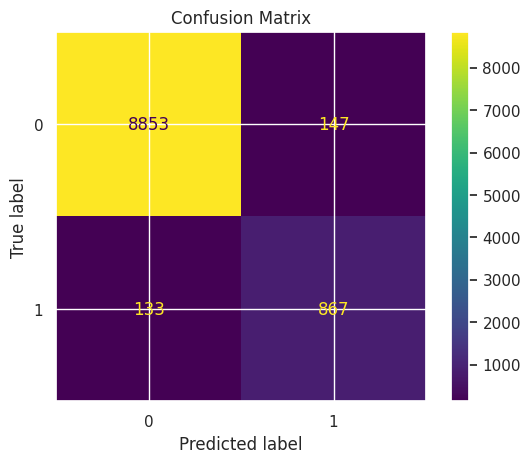

True Positives (TP): 867
False Negatives (FN): 133
False Positives (FP): 147
True Negatives (TN): 8853
Subgroup Accuracy for Sneaker Class: 0.867
Subgroup Accuracy for Non-Sneaker Class: 0.9836666666666667


In [25]:
# YOUR CODE HERE
# Obtain predictions on the test dataset
y_pred = (model_tf2.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculate TP, FN, FP, TN
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]
TN = cm[0, 0]

print("True Positives (TP):", TP)
print("False Negatives (FN):", FN)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)

# Compute subgroup accuracy separately for sneaker and non-sneaker classes
sneaker_indices = np.where(Y_test == 1)[0]
non_sneaker_indices = np.where(Y_test == 0)[0]

sneaker_accuracy = np.mean(y_pred[sneaker_indices] == Y_test[sneaker_indices])
non_sneaker_accuracy = np.mean(y_pred[non_sneaker_indices] == Y_test[non_sneaker_indices])

print("Subgroup Accuracy for Sneaker Class:", sneaker_accuracy)
print("Subgroup Accuracy for Non-Sneaker Class:", non_sneaker_accuracy)

While the model performs well overall, demonstrating strong generalization capabilities for the non-sneaker class, it shows relatively weaker performance for the sneaker class. The observed accuracy differences between the two classes indicate that the model may not generalize equally well across all subgroups.

----
### <span style="color:chocolate">Bonus question</span> (20 points)

Is it possible to enhance the prediction accuracy for the sneaker class by performing the following steps?

1. Implement data balancing techniques, such as oversampling or undersampling, to equalize the representation of both classes.
2. After balancing the data, retrain the model on the balanced dataset.
3. Evaluate the model's performance, particularly focusing on the accuracy achieved for the sneaker class.

Note: provide a separate notebook for the Bonus exercise. Name it ``04 Logistic Regression with Tensorflow_bonus``.